<a href="https://colab.research.google.com/github/KAYA-a/Double_H/blob/master/Flicker8k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

------------------------------------------------------------------------
# **IMPORT CAPTION AND IMAGE DATA**


In [15]:
from google.colab import auth
auth.authenticate_user()

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [16]:
ls /content/gdrive/'My Drive'/DB/

Flicker8k_Dataset/  Flickr8k_text/


In [17]:
ls /content/gdrive/'My Drive'/DB/Flickr8k_text

CrowdFlowerAnnotations.txt  Flickr8k.lemma.token.txt  Flickr_8k.trainImages.txt
ExpertAnnotations.txt       Flickr_8k.testImages.txt  readme.txt
Flickr_8k.devImages.txt     Flickr8k.token.txt


------------------------------------------------------------------------
# **Preliminary analysis**


In [0]:
import os
import sys
import time
import warnings

import tensorflow as tf
import keras
from keras.backend.tensorflow_backend import set_session
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter

from keras.preprocessing.image import load_img, img_to_array

In [19]:
db_loc = "/content/gdrive/My Drive/DB/"
dir_Flickr_jpg = db_loc + "/Flicker8k_Dataset/"
dir_Flickr_text = db_loc + "/Flickr8k_text/Flickr8k.token.txt"
jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8109


* Flicker8k.token.txt file conts

> 1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
> 1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .                    
> 1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .                    
> 1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
> 1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .



# load the text data 





In [20]:
file = open(dir_Flickr_text, 'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
  col = line.split('\t')
  if len(col) == 1:
    continue
  w = col[0].split("#") # w = ['filename', 'index'] index : unique ID for each caption for the same image
  datatxt.append(w + [col[1].lower()]) # col[1].lower() : 'caption'

  
df_txt = pd.DataFrame(datatxt, columns=["filename", "index", "caption"]) # type(df_txt) = numpy
uni_filenames = np.unique(df_txt.filename.values)

print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
#Counter(df_txt.filename.values) # dictionary {filename : the number of captions of filename}
Counter(Counter(df_txt.filename.values).values())


The number of unique file names : 8092
The distribution of the number of captions for each image:


Counter({5: 8092})

# EXAMPLE OF IMAGE AND CAPTION DATA

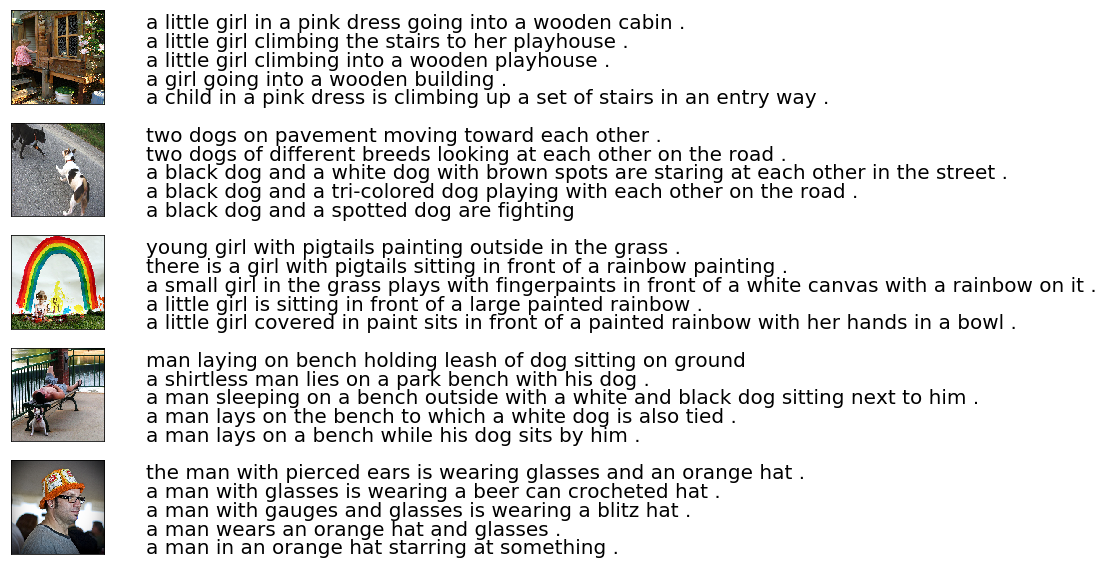

In [35]:
npic = 5
npix = 224
target_size = (npix, npix, 3)

count = 1
fig = plt.figure(figsize=(5,10))
for jpgfnm in uni_filenames[:npic]:
  filename = dir_Flickr_jpg + '/' + jpgfnm
  captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)  # if, filename match, get the captions value 
  image_load = load_img(filename, target_size=target_size)

  ax = fig.add_subplot(npic, 2, count, xticks=[], yticks=[])
  ax.imshow(image_load)
  count += 1
  
  ax = fig.add_subplot(npic, 2, count) 
  plt.axis('off') # get rid of calibration/graduation 
  ax.plot()
  ax.set_xlim(0,1)
  ax.set_ylim(0,len(captions))
  
  for i, caption in enumerate(captions):
    ax.text(0,i,caption,fontsize=20)
  count += 1
plt.show()

-------------
# **DATA PREPARATION**

# Text preparation

In [32]:
def df_word(df_txt):
  vocabulary = []
  for txt in df_txt.caption.values:  # txt : a sentence of caption
    vocabulary.extend(txt.split())  # blank excluded words add ## extend : iterable variables add
  print('Vocabulary Size : %d' % len(set(vocabulary)))
  ct = Counter(vocabulary) # dictionary type , key : word & values : count 
  
  dfword = pd.DataFrame({"word":ct.keys(), "count":ct.values()}) # two-dimensional mutable-size table 
#  print(dfword)  : index count values table --> 8919(8918+variable explanation) by 3
  dfword = dfword.sort_values("count", ascending=False)
#  print(dfword) # : sort by descending according to count variable
  dfword = dfword.reset_index()[["word", "count"]] # re-indexing with this status
#  print(dfword)
  return(dfword)
  
  
dfword = df_word(df_txt)
dfword.head(3) # showing 


Vocabulary Size : 8918


,word,count
0,a,62989
1,.,36581
2,in,18975


# The most and least frequently appearing words

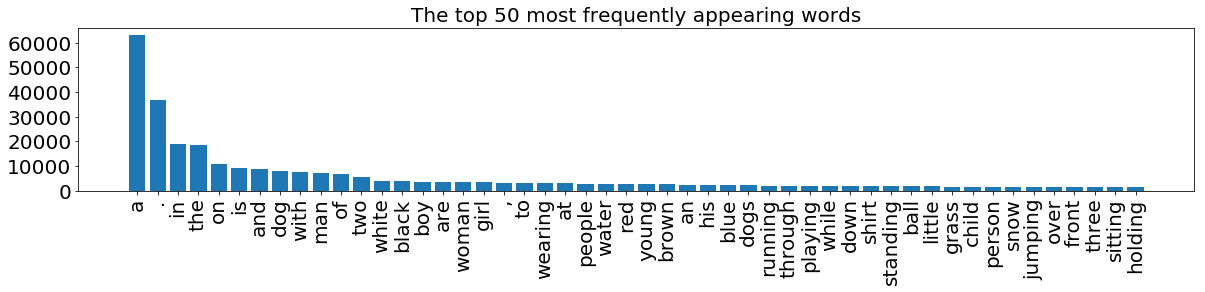

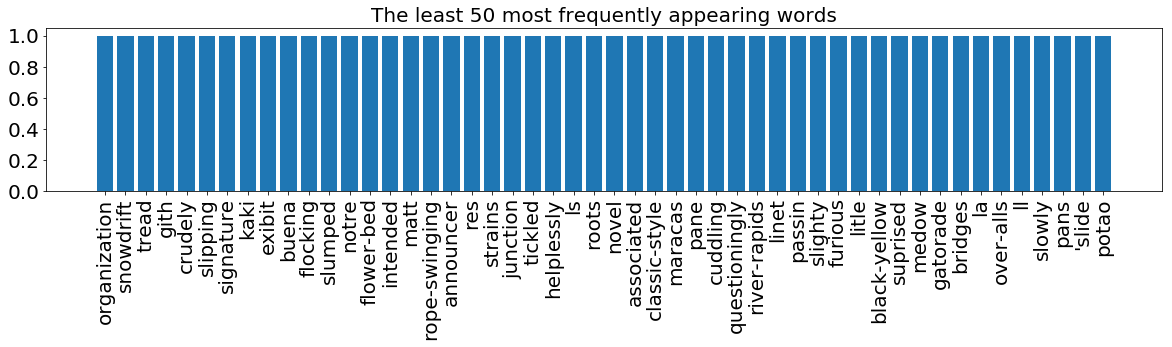

In [37]:
topn = 50

def plt_hist(dfsub, title=""):
  plt.figure(figsize=(20,3))
  plt.bar(dfsub.index, dfsub["count"])
  plt.yticks(fontsize=20)
  plt.xticks(dfsub.index,dfsub["word"], rotation=90, fontsize=20) # set text labels and properties 
  plt.title(title, fontsize=20)
  plt.show()
  
  
# iloc : numpy style array indexing method  
plt_hist(dfword.iloc[:topn,:], title="The top " + str(topn) + " most frequently appearing words")
plt_hist(dfword.iloc[-topn:,:], title="The least " + str(topn) + " most frequently appearing words")

# Remove 1) Puncuation, 2) Single character, 3) Numeric characters

In [46]:
import string

def remove_punctuation(_text): # _test : a sentence like I ate 1000 apples and a banana.
  text_no_punctuation = _text.translate(None, string.punctuation) # NONE : translated table, delete: punctuation
  return(text_no_punctuation)

def remove_single_character(_text):
  text_len_more_than1 = ""
  for word in _text.split():
    if len(word) > 1:
      text_len_more_than1 += " " + word
  return(text_len_more_than1)
      

def remove_numeric(_text, printTF=False):
  text_no_numeric = ""
  for word in _text.split():
    isalpha = word.isalpha()
    if printTF:
      pass
#      print(" {:10} : {:}".format(word, isalpha))
    if isalpha:
      text_no_numeric += " " + word
      
  return(text_no_numeric)


example = 'I ate 1000 apples and a banana.'
print(remove_punctuation(example))
print(remove_single_character(example))
print(remove_numeric(example, printTF=True)) # punctuation is regarded as non-alpha




I ate 1000 apples and a banana
 ate 1000 apples and banana.
 I ate apples and a


In [50]:
def text_clean(text_original):
  text = remove_punctuation(text_original)
  text = remove_single_character(text)
  text = remove_numeric(text)
  return text


#print(df_txt["caption"]) : table index and caption sentence 

for i, caption in enumerate(df_txt.caption.values):
  print(i)
  newcaption = text_clean(caption)
  df_txt["caption"].iloc[i] = newcaption
  

#print(df_txt["caption"])  


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Vocabulary Size : 8763


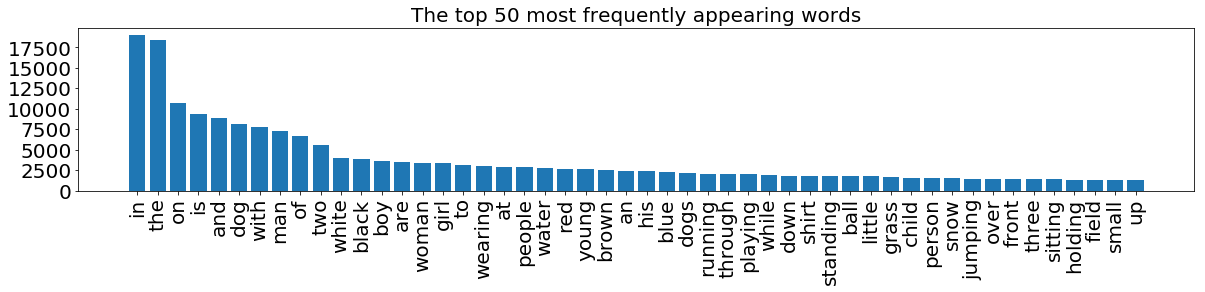

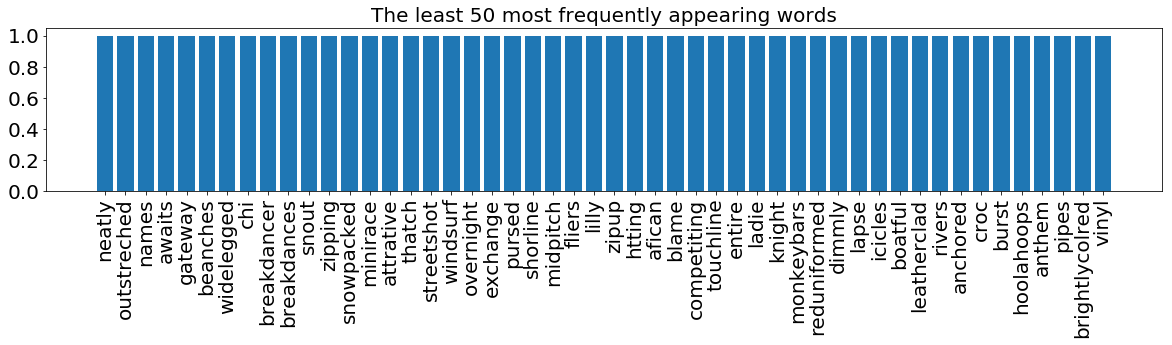

In [51]:
dfword = df_word(df_txt)
plt_hist(dfword.iloc[:topn,:], title="The top " + str(topn) + " most frequently appearing words")
plt_hist(dfword.iloc[-topn:,:], title="The least " + str(topn) + " most frequently appearing words")

# **Add start and end sequence tokens**

In [53]:
from copy import copy

def add_start_and_end_seq_token(captions):
  caps = []
  for txt in captions:
    txt = 'startseq ' + txt + ' endseq'
    caps.append(txt)
  return caps


df_txt0 = copy(df_txt)
df_txt0["captions"] = add_start_and_end_seq_token(df_txt["caption"])
df_txt0.head(5)

,filename,index,caption,captions
0,1000268201_693b08cb0e.jpg,0,child in pink dress is climbing up set of sta...,startseq child in pink dress is climbing up s...
1,1000268201_693b08cb0e.jpg,1,girl going into wooden building,startseq girl going into wooden building endseq
2,1000268201_693b08cb0e.jpg,2,little girl climbing into wooden playhouse,startseq little girl climbing into wooden pla...
3,1000268201_693b08cb0e.jpg,3,little girl climbing the stairs to her playhouse,startseq little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,4,little girl in pink dress going into wooden c...,startseq little girl in pink dress going into...
